SENTIMENT CLASSIFICATION ON AMAZON MOVIE REVIEWS

CIS 563 – Intro to Data Science

Harper He

Email: xhe128@syr.edu | Student ID: 331490565

In [1]:
import time
import timeit
start = time.time()
print(start)

1575773019.5318599


In [2]:
# import packages
# nltk related
import nltk
from nltk.tokenize import *
from nltk.corpus import *
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# sklearn related

# feature 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# classifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics, neighbors

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import SCORERS
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# others
import pandas as pd
#pd.set_option('display.max_rows',None)
#pd.set_option('max_colwidth',500)
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
import matplotlib.pyplot as plt 
%matplotlib inline
import random
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np

In [3]:
# extracts only useful texts
reviews=[]
movies_score=[]
movies_help=[]
with open("movies.txt",encoding = 'ISO-8859-1') as movies:
    for line in movies:
        if(line.startswith("review/text:")):
            each_line = line.split("review/text:")[1]
            #each_line = each_line.replace('<br /><br />','')
            each_line = each_line.replace('<br />',' ')
            each_line = each_line.replace('\n','')
            reviews.append(each_line)
        if(line.startswith("review/score:")):    
            each_score = line.split("review/score:")[1]
            each_score = each_score.replace('\n','')
            movies_score.append(each_score)
        if(line.startswith("review/helpfulness:")): 
            each_help = line.split("review/helpfulness:")[1]
            each_help = each_help.replace('\n','')
            #final_help = [x.split('/')[0] for x in each_help]
            movies_help.append(each_help)
print(len(reviews))
print(len(movies_score))
print(len(movies_help))
print(reviews[5])
print(movies_score[:5])
print(movies_help[:5])

7911684
7911684
7911684
 The murders in Juarez are real. This movie is a badly acted fantasy of revenge and holy intercession.  If there is a good movie about Juarez, I don't know what it is, but it is not this one.
[' 3.0', ' 3.0', ' 5.0', ' 3.0', ' 3.0']
[' 7/7', ' 4/4', ' 8/10', ' 1/1', ' 1/1']


In [4]:
data = {'reviews':reviews,'movies_score':movies_score,'movies_help':movies_help}
df=pd.DataFrame(data)
df.head()

,reviews,movies_score,movies_help
0,"Synopsis: On the daily trek from Juarez, Mexi...",3.0,7/7
1,THE VIRGIN OF JUAREZ is based on true events ...,3.0,4/4
2,The scenes in this film can be very disquieti...,5.0,8/10
3,THE VIRGIN OF JUAREZ (2006) directed by Kevin...,3.0,1/1
4,"Informationally, this SHOWTIME original is es...",3.0,1/1


In [5]:
df['movies_score']=df['movies_score'].astype(float)
len(df)

7911684

In [6]:
# check the distribution of scores
rating_count=pd.value_counts(df['movies_score'].values, sort=True)
rating_count

5.0    4380544
4.0    1654815
3.0     791594
1.0     629332
2.0     455399
dtype: int64

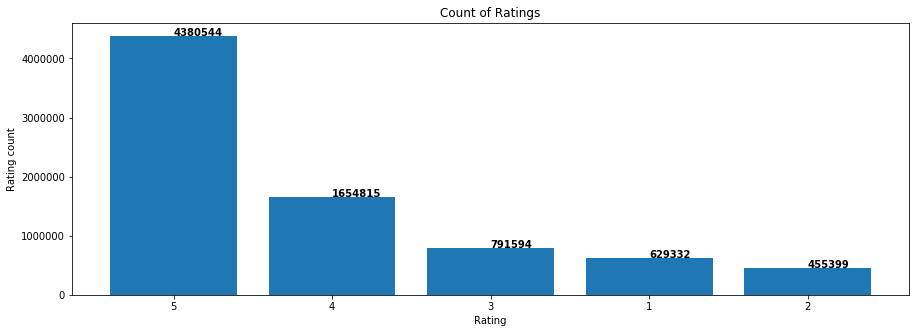

In [7]:
Index = [1,2,3,4,5]
plt.figure(figsize=(15,5))
plt.bar(Index,rating_count,color ='grey')
plt.xticks(Index,['5','4','3','1','2'])
plt.ylabel('Rating count')
plt.xlabel('Rating')
plt.title('Count of Ratings')
plt.bar(Index, rating_count)
for a,b in zip(Index, rating_count):
    plt.text(a, b, str(b) ,color='black', fontweight='bold')

In [8]:
df = df[df.movies_score != 3.0]
df.head()

,reviews,movies_score,movies_help
2,The scenes in this film can be very disquieti...,5.0,8/10
5,The murders in Juarez are real. This movie is...,2.0,0/0
6,"Mexican men are macho rapists, gangsters or i...",1.0,3/11
7,"Over the past few years, public television ha...",5.0,64/65
8,I recvd this video (DVD version) as a Christm...,5.0,26/26


In [9]:
df['movies_help'] = df['movies_help'].astype(str)
df['movies_help'] = df['movies_help'].apply(lambda x: x.split('/')[0])
df['movies_help'] = df['movies_help'].astype(int)
df = df[df.movies_help > 80]
print(len(df))
df.head()

34552


,reviews,movies_score,movies_help
129,"After attending the release of ""The Count of ...",5.0,253
130,In this time of fire and explosion oriented b...,5.0,104
131,If you have never discovered the wonderful wo...,4.0,85
487,This review refers to the Warner Bros. DVD ed...,5.0,134
689,"As a Japanese living in the United Staes, I c...",5.0,87


In [10]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split()]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

df['words'] = df.reviews.apply(lambda x: clean_text(x))

In [11]:
df.head()

,reviews,movies_score,movies_help,words
129,"After attending the release of ""The Count of ...",5.0,253,attend release count monte cristo friend make ...
130,In this time of fire and explosion oriented b...,5.0,104,time fire explosion orient blockbuster movie i...
131,If you have never discovered the wonderful wo...,4.0,85,never discover wonderful world alexandre duma ...
487,This review refers to the Warner Bros. DVD ed...,5.0,134,review refer warner bros dvd edition quotthe t...
689,"As a Japanese living in the United Staes, I c...",5.0,87,japanese live unite staes say totally film ama...


In [12]:
def remove_numbers(words):
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
df['words']=remove_numbers(df['words'])

In [13]:
len(df)

34552

In [14]:
df.head()

,reviews,movies_score,movies_help,words
129,"After attending the release of ""The Count of ...",5.0,253,attend release count monte cristo friend make ...
130,In this time of fire and explosion oriented b...,5.0,104,time fire explosion orient blockbuster movie i...
131,If you have never discovered the wonderful wo...,4.0,85,never discover wonderful world alexandre duma ...
487,This review refers to the Warner Bros. DVD ed...,5.0,134,review refer warner bros dvd edition quotthe t...
689,"As a Japanese living in the United Staes, I c...",5.0,87,japanese live unite staes say totally film ama...


In [15]:
df['label']=''
df['label'][df['movies_score'] >= 4.0] = 'pos'
df['label'][df['movies_score'] <= 2.0] = 'neg'

In [16]:
df.label.value_counts()

pos    30216
neg     4336
Name: label, dtype: int64

In [17]:
df.head()

,reviews,movies_score,movies_help,words,label
129,"After attending the release of ""The Count of ...",5.0,253,attend release count monte cristo friend make ...,pos
130,In this time of fire and explosion oriented b...,5.0,104,time fire explosion orient blockbuster movie i...,pos
131,If you have never discovered the wonderful wo...,4.0,85,never discover wonderful world alexandre duma ...,pos
487,This review refers to the Warner Bros. DVD ed...,5.0,134,review refer warner bros dvd edition quotthe t...,pos
689,"As a Japanese living in the United Staes, I c...",5.0,87,japanese live unite staes say totally film ama...,pos


In [18]:
df=df.drop(columns=['reviews','movies_score','movies_help'])

In [19]:
df.head()

,words,label
129,attend release count monte cristo friend make ...,pos
130,time fire explosion orient blockbuster movie i...,pos
131,never discover wonderful world alexandre duma ...,pos
487,review refer warner bros dvd edition quotthe t...,pos
689,japanese live unite staes say totally film ama...,pos


In [20]:
print(len(df[df['label']==('pos')]))
print(len(df[df['label']==('neg')]))

30216
4336


In [21]:
len(df)

34552

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df['words'],df['label'], test_size=0.20, random_state=7)
classes = df['label'].unique()

In [23]:
print(len(X_train))
print(len(X_test))

27641
6911


In [24]:
X_train[:1]

2422263    ever attend family reunion sit extend family h...
Name: words, dtype: object

In [25]:
pos_train=y_train[y_train==('pos')]
print(len(pos_train))
neg_train=y_train[y_train==('neg')]
print(len(neg_train))
no_info_ratio = max((len(pos_train)/(len(pos_train)+len(neg_train))),(len(neg_train)/(len(pos_train)+len(neg_train))))
no_info_ratio

24156
3485


0.8739191780326326

Feature Extraction

In [26]:
# bow

In [27]:
bow_vectorizer = CountVectorizer(analyzer='word', max_features=3000)
bow_X_train = bow_vectorizer.fit_transform(X_train).toarray()
bow_X_test= bow_vectorizer.transform(X_test).toarray()

In [28]:
# TF-IDF

In [29]:
tf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1,1), max_features=3000) 
tf_X_train = tf_vectorizer.fit_transform(X_train).toarray()
tf_X_test= tf_vectorizer.transform(X_test).toarray()

In [30]:
# training 

In [31]:
# knn model

In [32]:
def dt_train(X_train,y_train):
    dt = DecisionTreeClassifier()
    dt=dt.fit(X_train, y_train)
    scores = cross_val_score(dt, X_train, y_train, cv=3)
    print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print(scores)    
    
def nb_train(X_train,y_train):
    nb = MultinomialNB()
    nb=nb.fit(X_train, y_train)
    scores = cross_val_score(nb, X_train, y_train, cv=3)
    print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print(scores)
    
def knn_train(X_train,y_train):
    knn = neighbors.KNeighborsClassifier(n_neighbors=5, 
                                         weights='uniform', 
                                         algorithm='auto', leaf_size=30, p=2, 
                                         metric='jaccard', metric_params=None, n_jobs=1)

    knn=knn.fit(X_train, y_train)
    scores = cross_val_score(knn, X_train, y_train, cv=3)
    print("Cross Validation Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    print(scores)    

In [33]:
dt_train(bow_X_train,y_train)

Cross Validation Accuracy: 0.9700 (+/- 0.0038)
[0.97015411 0.96765791 0.97232172]


In [34]:
dt_train(tf_X_train,y_train)

Cross Validation Accuracy: 0.9717 (+/- 0.0023)
[0.97015411 0.97265031 0.97243026]


In [35]:
nb_train(bow_X_train,y_train)

Cross Validation Accuracy: 0.8578 (+/- 0.0060)
[0.85652268 0.86194921 0.85487898]


In [36]:
nb_train(tf_X_train,y_train)

Cross Validation Accuracy: 0.9145 (+/- 0.0022)
[0.91393532 0.91350119 0.91598828]


In [37]:
knn_train(bow_X_train,y_train)

Cross Validation Accuracy: 0.9537 (+/- 0.0028)
[0.95278923 0.95257217 0.95560621]


In [38]:
knn_train(tf_X_train,y_train)

Cross Validation Accuracy: 0.9534 (+/- 0.0020)
[0.95300629 0.95246364 0.95484641]


In [48]:
dt = DecisionTreeClassifier()
dt=dt.fit(bow_X_train, y_train)
predictions = dt.predict(bow_X_test)
acc = metrics.accuracy_score(y_test, predictions)
pre = precision_score(y_test, predictions,average="binary",pos_label="pos")
rec = recall_score(y_test, predictions,average="binary", pos_label="pos")
cnf_matrix=confusion_matrix(y_test, predictions)
print('Testing: DT with BOW accuracy = ' + str(acc * 100) + '%')
print(classification_report(y_test, predictions))
print(cnf_matrix)

Testing: DT with BOW accuracy = 97.91636521487483%
              precision    recall  f1-score   support

         neg       0.91      0.92      0.92       851
         pos       0.99      0.99      0.99      6060

   micro avg       0.98      0.98      0.98      6911
   macro avg       0.95      0.95      0.95      6911
weighted avg       0.98      0.98      0.98      6911

[[ 785   66]
 [  78 5982]]


In [49]:
y_pred_proba = dt.predict_proba(bow_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba,pos_label='pos')
auc = metrics.roc_auc_score(y_test, y_pred_proba)

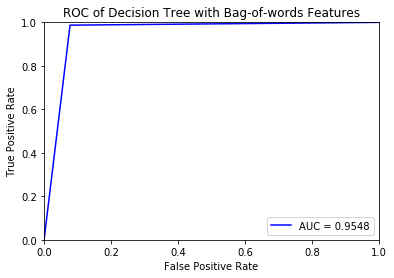

In [50]:
plt.title('ROC of Decision Tree with Bag-of-words Features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [51]:
dt = DecisionTreeClassifier()
dt=dt.fit(tf_X_train, y_train)
predictions = dt.predict(tf_X_test)
acc = metrics.accuracy_score(y_test, predictions)
pre = precision_score(y_test, predictions,average="binary",pos_label="pos")
rec = recall_score(y_test, predictions,average="binary", pos_label="pos")
cnf_matrix=confusion_matrix(y_test, predictions)
print('Testing: DT with TF-IDF accuracy = ' + str(acc * 100) + '%')
print(classification_report(y_test, predictions))
print(cnf_matrix)

Testing: DT with TF-IDF accuracy = 98.1912892490233%
              precision    recall  f1-score   support

         neg       0.92      0.93      0.93       851
         pos       0.99      0.99      0.99      6060

   micro avg       0.98      0.98      0.98      6911
   macro avg       0.96      0.96      0.96      6911
weighted avg       0.98      0.98      0.98      6911

[[ 791   60]
 [  65 5995]]


In [52]:
y_pred_proba = dt.predict_proba(tf_X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba,pos_label='pos')
auc = metrics.roc_auc_score(y_test, y_pred_proba)

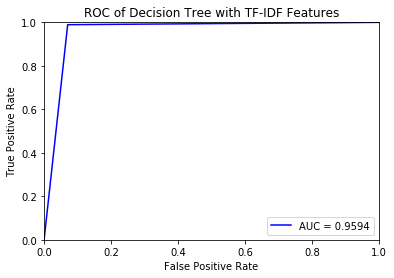

In [53]:
plt.title('ROC of Decision Tree with TF-IDF Features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [46]:
elapsed = (time.time() - start)
print("Time used:",elapsed)

Time used: 4981.689297199249
